In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler # StandardScaler

from sklearn.metrics import mean_squared_error

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import matplotlib.pyplot as plt

import joblib

In [2]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
j = pd.read_csv('data/J(배).csv', header=0)
j.head()

,date,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
0,2019-10-18 19:48:00,2.287,2.336,0.000,0,136.368,0,0.000,410.256
1,2019-10-18 19:49:00,2.290,2.332,0.000,0,134.696,0,0.000,430.988
2,2019-10-18 19:50:00,2.284,2.336,0.000,0,137.882,0,0.000,440.624
3,2019-10-18 19:51:00,2.290,2.331,0.000,0,138.478,0,0.000,453.675
4,2019-10-18 19:52:00,2.284,2.330,0.000,0,134.451,0,0.000,448.864


In [4]:
j.describe()

,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
count,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000
mean,2.833,2.957,7651.998,150.048,334.790,74.439,6594.258,304.030
std,0.851,0.618,874445.828,17147.015,152.779,8506.669,753570.709,98.444
min,0.000,0.000,0.000,0.000,-966.718,0.000,0.000,-119.992
25%,2.713,2.762,0.000,0.000,259.000,0.000,0.000,231.979
50%,3.031,3.049,0.000,0.000,300.200,0.000,0.000,308.723
75%,3.313,3.316,0.000,0.000,367.000,0.000,0.000,369.000
max,4.019,4.069,99936460.000,1959678.000,2113.655,972199.000,86124350.000,1391.800


In [5]:
j['date'] = pd.to_datetime(j['date'])
j.set_index('date', inplace=True)

In [6]:
j.loc[j['height1'] <= 1, 'height1'] = np.nan

In [7]:
median_value = j['height1'].median()
j['height1'] = j['height1'].fillna(median_value)
# mean_value = j['height1'].mean()
# j['height1'] = j['height1'].fillna(mean_value)

In [8]:
j.loc[j['height2'] <= 1, 'height2'] = np.nan

In [9]:
# median_value = j['height2'].median()
# j['height2'] = j['height2'].fillna(median_value)
mean_value = j['height2'].mean()
j['height2'] = j['height2'].fillna(mean_value)

In [10]:
j.loc[(j['in_flow'] > 800), 'in_flow'] = np.nan

In [11]:
j['in_flow'] = j['in_flow'].interpolate(method='linear')

In [12]:
j.loc[(j['in_flow'] < 0), 'in_flow'] = np.nan
j['in_flow'] = j['in_flow'].ffill()

In [13]:
j.loc[(j['out_flow'] > 800) , 'out_flow'] = np.nan
j['out_flow'] = j['out_flow'].interpolate(method='linear')

In [14]:
j.loc[(j['in_flow'] < 0), 'out_flow'] = np.nan
j['out_flow'] = j['out_flow'].ffill()

In [15]:
j.describe()

,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
count,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000
mean,3.045,3.037,7651.998,150.048,325.797,74.439,6594.258,304.026
std,0.382,0.383,874445.828,17147.015,115.984,8506.669,753570.709,98.429
min,1.001,1.001,0.000,0.000,0.000,0.000,0.000,-119.992
25%,2.816,2.796,0.000,0.000,258.900,0.000,0.000,231.978
50%,3.071,3.049,0.000,0.000,300.000,0.000,0.000,308.722
75%,3.313,3.316,0.000,0.000,366.100,0.000,0.000,369.000
max,4.019,4.069,99936460.000,1959678.000,800.000,972199.000,86124350.000,722.570


In [16]:
j = j.resample('h').mean()
j.head(), j.tail()

(                     height1  height2  in_valve1  in_valve2  in_flow  \
 date                                                                   
 2019-10-18 19:00:00    2.278    2.325      0.000      0.000  135.767   
 2019-10-18 20:00:00    2.325    2.368      0.000      0.000  451.579   
 2019-10-18 21:00:00    2.387    2.424      0.000      0.000  285.715   
 2019-10-18 22:00:00    2.389    2.421      0.000      0.000  269.691   
 2019-10-18 23:00:00    2.376    2.408      0.000      0.000  175.643   
 
                      out_valve1  out_valve2  out_flow  
 date                                                   
 2019-10-18 19:00:00       0.000       0.000   444.767  
 2019-10-18 20:00:00       0.000       0.000   352.897  
 2019-10-18 21:00:00       0.000       0.000   426.186  
 2019-10-18 22:00:00       0.000       0.000   336.389  
 2019-10-18 23:00:00       0.000       0.000   320.777  ,
                      height1  height2  in_valve1  in_valve2  in_flow  \
 date         

In [17]:
start_date = pd.Timestamp('2019-10-18 20:00:00')
end_date = pd.Timestamp('2022-06-30 23:59:00')

# 주어진 기간 내의 데이터를 sample로 설정
sample_df = j[(j.index >= start_date) & (j.index <= end_date)]

sample_df

,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
date,,,,,,,,
2019-10-18 20:00:00,2.325,2.368,0.000,0.000,451.579,0.000,0.000,352.897
2019-10-18 21:00:00,2.387,2.424,0.000,0.000,285.715,0.000,0.000,426.186
2019-10-18 22:00:00,2.389,2.421,0.000,0.000,269.691,0.000,0.000,336.389
2019-10-18 23:00:00,2.376,2.408,0.000,0.000,175.643,0.000,0.000,320.777
2019-10-19 00:00:00,2.416,2.464,0.000,0.000,381.217,0.000,0.000,293.171
...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00,3.129,3.114,0.000,0.000,245.008,0.000,0.000,406.098
2022-06-30 20:00:00,2.987,2.977,0.000,0.000,244.290,0.000,0.000,434.142
2022-06-30 21:00:00,2.836,2.830,0.000,0.000,245.970,0.000,0.000,428.195


In [18]:
train_start = start_date
train_end = pd.Timestamp('2021-08-31 23:00:00')
val_start = pd.Timestamp('2021-09-01 00:00:00')
val_end = pd.Timestamp('2022-01-31 23:00:00')
test_start = pd.Timestamp('2022-02-01 00:00:00')
test_end = end_date

In [19]:
train_set = sample_df.loc[train_start:train_end]
val_set = sample_df.loc[val_start:val_end]
test_set = sample_df.loc[test_start:test_end]

train_set.shape, val_set.shape, test_set.shape

((16396, 8), (3672, 8), (3600, 8))

In [20]:
features = ['height1', 'height2', 'in_flow']
target = 'out_flow'

In [21]:
train_features = train_set[features]
train_target = train_set[[target]]
val_features = val_set[features]
val_target = val_set[[target]]
test_features = test_set[features]
test_target = test_set[[target]]

print(f'train_features의 shape', train_features.shape)
print(f'train_target의 shape', train_target.shape)
print(f'val_features의 shape', val_features.shape)
print(f'val_target의 shape', val_target.shape)
print(f'test_features의 shape', test_features.shape)
print(f'test_target의 shape', test_target.shape)

train_features의 shape (16396, 3)
train_target의 shape (16396, 1)
val_features의 shape (3672, 3)
val_target의 shape (3672, 1)
test_features의 shape (3600, 3)
test_target의 shape (3600, 1)


In [22]:
ft_scaler = MinMaxScaler()
tg_scaler = MinMaxScaler()

scaled_train_features = ft_scaler.fit_transform(train_features)
scaled_train_target = tg_scaler.fit_transform(train_target)

scaled_val_features = ft_scaler.transform(val_features)
scaled_val_target = tg_scaler.transform(val_target)

scaled_test_features = ft_scaler.transform(test_features)
scaled_test_target = tg_scaler.transform(test_target)

In [23]:
def create_sequences(features, target, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 48
X_train, y_train = create_sequences(scaled_train_features, scaled_train_target, seq_length)
X_val, y_val = create_sequences(scaled_val_features, scaled_val_target, seq_length)
X_test, y_test = create_sequences(scaled_test_features, scaled_test_target, seq_length)

print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_train.shape}')
print(f'y_test : {y_test.shape}')

X_train : (16348, 48, 3)
y_train : (16348, 1)
X_val : (3624, 48, 3)
y_val : (3624, 1)
X_test : (16348, 48, 3)
y_test : (3552, 1)


In [24]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [25]:
# CNN 모델 정의
class CNN(nn.Module): # cnn_out_channels : 학습 능력 향상 + 과적합 위험도 증가
    def __init__(self, input_dim, cnn_out_channels, cnn_kernel_size):
        super(CNN, self).__init__()
        # 1D Convolutional Layer: 입력 채널 수(input_dim), 출력 채널 수(cnn_out_channels), 커널 크기(cnn_kernel_size)
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=cnn_out_channels, kernel_size=cnn_kernel_size)
        # 모델이 복잡한 패턴을 학습할 수 있도록. 기울기 소실 문제 완화. 일반화 능력 향상
        self.relu = nn.ReLU()
        # Max Pooling Layer: kernel_size 클수록 출력 차원 줄어들어 > 과적합 방지 + 정보 손실 多
        self.pool = nn.MaxPool1d(kernel_size=2)
        # Relu 없이 pooling만 사용 시 중요한 정보만 손실
        
    def forward(self, x):
        # Convolutional Layer를 통과한 후 활성화 함수 적용
        x = self.conv1(x)
        x = self.relu(x)
        # Max Pooling 적용
        x = self.pool(x)
        return x

In [26]:
# LSTM 모델 정의
class LSTM(nn.Module): # 많을수록 복잡한 패턴 학습 + 과적합 위험 증가
    def __init__(self, input_size, hidden_size, num_layers, output_dim):
        super(LSTM, self).__init__()
        # LSTM Layer: 입력 크기(input_size), 숨겨진 노드 수(hidden_size), LSTM 층 수(num_layers)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # Fully Connected Layer: hidden_size에서 output_dim으로
        self.fc = nn.Linear(hidden_size, output_dim)
    
    def forward(self, x):
        # LSTM Layer를 통과한 후
        x, _ = self.lstm(x)
        # 마지막 타임 스텝의 출력을 Fully Connected Layer에 전달
        x = self.fc(x[:, -1, :])  # 마지막 시점의 출력을 사용
        return x

In [27]:
# CNN과 LSTM을 결합한 CNN-LSTM 모델 정의
class CNNLSTM(nn.Module): 
    def __init__(self, input_dim, cnn_out_channels, cnn_kernel_size, lstm_hidden_size, lstm_num_layers, output_dim):
        super(CNNLSTM, self).__init__()
        # CNN 인스턴스 생성
        self.cnn = CNN(input_dim, cnn_out_channels, cnn_kernel_size)
        # LSTM 인스턴스 생성
        self.lstm = LSTM(cnn_out_channels, lstm_hidden_size, lstm_num_layers, output_dim)
    
    def forward(self, x):
        # CNN Layer를 통과 (입력 데이터의 차원 순서 변경: (batch_size, channels, seq_length))
        x = self.cnn(x.permute(0, 2, 1))
        # LSTM Layer를 통과 (차원 순서 변경: (batch_size, seq_length, input_size))
        x = self.lstm(x.permute(0, 2, 1))
        return x

In [28]:
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, verbose):
    train_hist = []
    val_hist = []

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_val_loss = 0.0

        # Training
        model.train()
        for batch_X, batch_y in train_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            for batch_X_val, batch_y_val in val_loader:
                predictions_val = model(batch_X_val)
                val_loss = criterion(predictions_val, batch_y_val)
                total_val_loss += val_loss.item()

        average_train_loss = total_train_loss / len(train_loader)
        average_val_loss = total_val_loss / len(val_loader)

        train_hist.append(average_train_loss)
        val_hist.append(average_val_loss)

        # verbose 주기마다 loss 출력
        if (epoch + 1) % verbose == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

        # patience 주기마다 early stopping 여부 확인
        if (epoch + 1) % patience == 0 and epoch + 1 != 0:
            if val_hist[-patience] < average_val_loss:
                print('\nEarly Stopping')
                break

    return train_hist, val_hist

def evaluate_model(model, test_loader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    test_loss = 0.0
    predictions, actuals = [], []
    with torch.no_grad():  # 평가 시에는 그래디언트 계산을 하지 않음
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            predictions.append(outputs.numpy())
            actuals.append(targets.numpy())

    test_loss = test_loss / len(test_loader.dataset)
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    # 역변환
    predictions = tg_scaler.inverse_transform(predictions)
    actuals = tg_scaler.inverse_transform(actuals)
    
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    print(f'Test Loss: {test_loss:.4f}, CNN+LSTM RMSE: {rmse:.4f}')
    return predictions, actuals, rmse

In [35]:
# 모델 파라미터 설정
input_dim = len(features)
cnn_out_channels = 16 # 학습 능력 향상 + 과적합 위험도 증가
cnn_kernel_size = 3 # 클수록 출력 차원 줄어들어 > 과적합 방지 + 정보 손실 多
lstm_hidden_size = 50 # 많을수록 복잡한 패턴 학습 + 과적합 위험 증가
lstm_num_layers = 1 # 많을수록 복잡한 패턴 학습 + 과적합 위험 증가
output_dim = 1

# CNN-LSTM 모델 인스턴스 생성
model = CNNLSTM(input_dim, cnn_out_channels, cnn_kernel_size, lstm_hidden_size, lstm_num_layers, output_dim)
# 손실 함수 정의 (Mean Squared Error)
criterion = nn.MSELoss()
# 옵티마이저 정의 (Adam Optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 50
patience = 10
verbose = 10

train_hist, val_hist = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, verbose)
predictions, actuals, rmse = evaluate_model(model, test_loader, criterion)


Epoch [10/50] - Training Loss: 0.0109, Validation Loss: 0.0106
Epoch [20/50] - Training Loss: 0.0097, Validation Loss: 0.0088
Epoch [30/50] - Training Loss: 0.0090, Validation Loss: 0.0080
Epoch [40/50] - Training Loss: 0.0084, Validation Loss: 0.0085

Early Stopping
Test Loss: 0.0001, CNN+LSTM RMSE: 48.9655


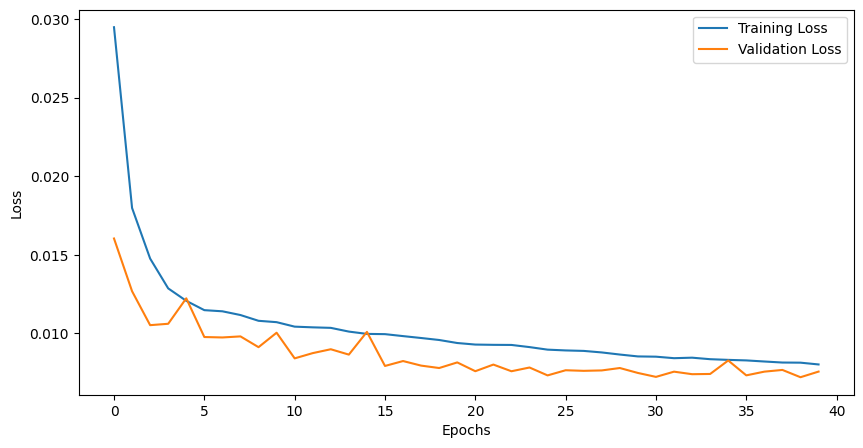

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(train_hist, label='Training Loss')
plt.plot(val_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
# 테스트 구간의 날짜를 가져오기
dates = test_set.index[seq_length:]

# 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': dates,
    'Actual': actuals.flatten(),
    'Predicted': predictions.flatten()
})

print(comparison_df)

                    Date  Actual  Predicted
0    2022-02-03 00:00:00 196.072    215.023
1    2022-02-03 01:00:00 184.871    162.241
2    2022-02-03 02:00:00 138.798    142.581
3    2022-02-03 03:00:00 131.191    124.382
4    2022-02-03 04:00:00 133.122    133.304
...                  ...     ...        ...
3547 2022-06-30 19:00:00 406.098    379.328
3548 2022-06-30 20:00:00 434.142    389.580
3549 2022-06-30 21:00:00 428.195    389.967
3550 2022-06-30 22:00:00 364.893    379.857
3551 2022-06-30 23:00:00 312.118    344.435

[3552 rows x 3 columns]


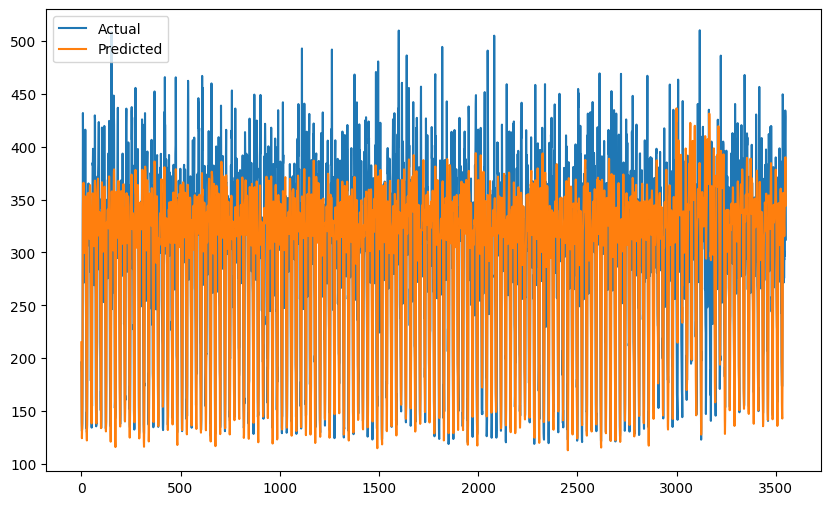

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()